# Backtest Demo with `TaoTrader`

In [1]:
# ✅ 初始化导入
from data.market_data import OKXDataFetcher
from core.context import BacktestContext
from core.strategy_registry import StrategyRegistry
from backtest.backtest_engine import BacktestEngine
from backtest.performance_metrics import analyze_performance
from execution.trade_logger import TradeLogger
from risk_management.risk_checker import RiskChecker
from utils.plots import plot_signals_on_price, plot_pnl_curve
from backtest.reporter import generate_markdown_report
from core.strategy_loader import load_all_strategies
from IPython.display import display, Markdown

load_all_strategies()

In [2]:
# 🧾 加载配置与数据
ctx = BacktestContext(
    strategy_config_path='configs/strategy/ma_crossover.yaml',
    backtest_config_path='configs/backtest.yaml',
    risk_config_path='configs/risk.yaml'
)

fetcher = OKXDataFetcher()
df = fetcher.get_kline('BTC-USDT-SWAP', bar='1H')
df.tail()

[2025-06-12 19:59:23] INFO - HTTP Request: GET https://www.okx.com/api/v5/market/candles?instId=BTC-USDT-SWAP&bar=1H&limit=300 "HTTP/2 200 OK"


,open,high,low,close,volume
timestamp,,,,,
2025-06-12 19:00:00,107521.2,107835.1,106628.0,106753.5,410940.18
2025-06-12 20:00:00,106753.5,106920.0,105712.2,105921.5,896171.19
2025-06-12 21:00:00,105921.6,106403.5,105800.3,105828.5,339409.23
2025-06-12 22:00:00,105828.4,106186.9,105666.0,105826.9,292820.17
2025-06-12 23:00:00,105826.9,106088.7,105718.7,105754.1,227158.74


In [3]:
# ⚙️ 初始化策略与组件
strategy_cls = StrategyRegistry.get("MA_Crossover")
trade_logger = TradeLogger()
risk_checker = RiskChecker(ctx)

engine = BacktestEngine(
    strategy_class=strategy_cls,
    data=df,
    context=ctx,
    trade_logger=trade_logger,
    risk_checker=risk_checker
)
engine.run()
unrealized = engine.get_unrealized()

[2025-06-12 19:59:41] INFO - Starting backtest engine run...
[2025-06-12 19:59:41] INFO - [Signal] Strong crossover at index 28 → long_strong
[2025-06-12 19:59:41] INFO - Opening new position at index 28 with signal long_strong
[2025-06-12 19:59:41] INFO - [Stop Loss] Triggered at price 100434.90 (entry=104973.40)
[2025-06-12 19:59:41] INFO - Stop loss triggered at index 128
[2025-06-12 19:59:41] INFO - [Signal] Medium crossover at index 139 → long_medium
[2025-06-12 19:59:41] INFO - Opening new position at index 139 with signal long_medium
[2025-06-12 19:59:41] INFO - [Unrealized] Holding position at end → {'entry_time': Timestamp('2025-06-06 07:00:00'), 'entry_price': np.float64(103102.1), 'current_price': np.float64(105754.1), 'qty': np.float64(0.4635147368729146), 'capital': np.float64(47789.34275254493), 'direction': 'long', 'pnl_dollar': np.float64(1180.837118893331), 'pnl_pct': np.float64(0.024709214458289403)}
[2025-06-12 19:59:41] INFO - Backtest engine run completed.


In [5]:
# 📊 回测结果分析
trades_df = trade_logger.to_dataframe()
perf = analyze_performance(trades_df, unrealized=unrealized)

def show_perf(perf):
    md = "\n".join([f"- **{k}**: {v}" for k, v in perf.items()])
    display(Markdown("##Performance Summary\n" + md))

show_perf(perf)
trades_df.tail()

##Performance Summary
- **Total Trades**: 1
- **Total PnL ($)**: -3240.48
- **Average PnL ($)**: -3240.48
- **Unrealized Position**: {'entry_time': Timestamp('2025-06-06 07:00:00'), 'entry_price': np.float64(103102.1), 'current_price': np.float64(105754.1), 'qty': np.float64(0.4635147368729146), 'capital': np.float64(47789.34275254493), 'direction': 'long', 'pnl_dollar': np.float64(1180.837118893331), 'pnl_pct': np.float64(0.024709214458289403)}

,entry_time,exit_time,entry_price,exit_price,qty,capital,direction,pnl_pct,pnl_dollar,signal,exit_reason
0,2025-06-01 16:00:00,2025-06-05 20:00:00,104973.4,100434.9,0.952622,100000.0,long,-0.044213,-4421.314495,long_strong,stop_loss


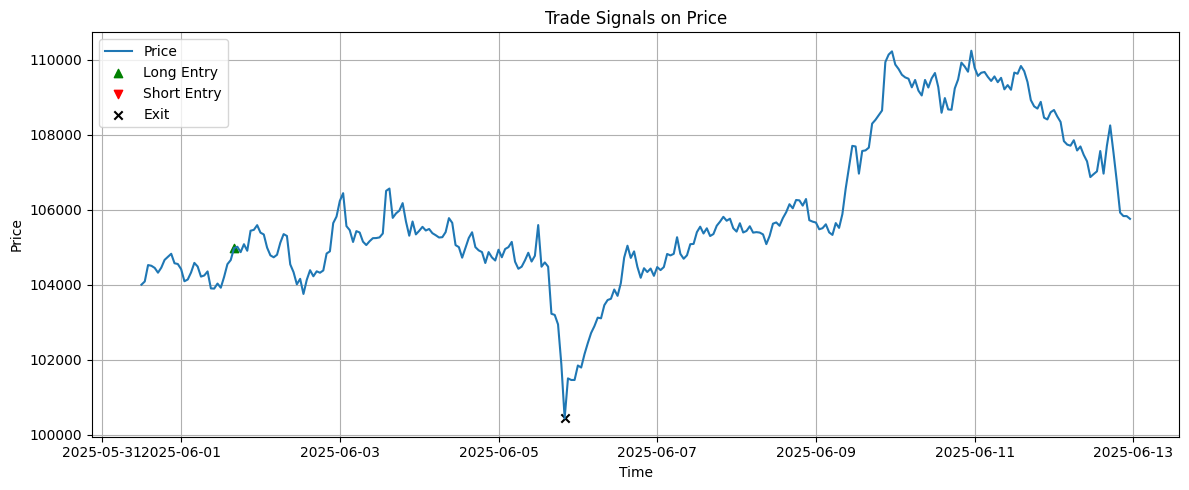

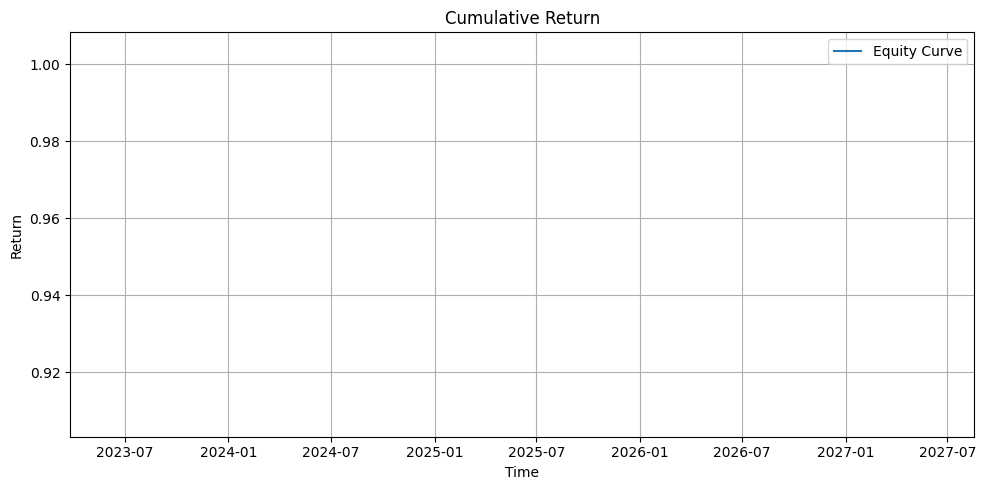

In [6]:
# 可视化买卖点与PnL曲线
plot_signals_on_price(df, trades_df)
plot_pnl_curve(trades_df)

In [7]:
# 导出Markdown报告
generate_markdown_report(trades_df, perf, unrealized)

[2025-06-12 20:00:32] INFO - Markdown report saved to: reports\backtest_report_20250612.md
